In [225]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [226]:
client = MongoClient('mongodb://localhost:27017/')

db = client['RoadsConditions']
collection = db['StructuredData']

data = list(collection.find())
df = pd.DataFrame(data)

if '_id' in df.columns:
    df.drop(['_id', 'direction', 'isAdmin'], axis=1, inplace=True)

df = df[df['city'].isin(["نابلس","رام الله"])]
df = df[df['status'] != 'مغلق']
df.drop(['city', 'group'], axis=1, inplace=True)
df

,sentTime,checkpoint,status
0,2024-12-18 12:47:56,دير شرف,ازمة
1,2024-12-18 12:48:45,دير شرف,ازمة
2,2024-12-18 12:48:46,DCO,مفتوح
3,2024-12-18 12:49:15,المربعة,مفتوح
4,2024-12-18 12:50:17,مخماس,مفتوح
...,...,...,...
11849,2025-01-03 12:57:34,صرة,مفتوح
11850,2025-01-03 12:56:00,صرة,مفتوح
11851,2025-01-03 12:51:42,عين سينيا,مفتوح
11853,2025-01-03 12:57:15,عورتا,مفتوح


In [227]:
status_mapping = {
    "مفتوح": "Open",
    "حاجز": "Open",
    "ازمة خفيفة": "Traffic",
    "ازمة خانقة": "Traffic",
    "ازمة": "Traffic"
}

df['status_mapped'] = df['status'].map(status_mapping)
unmapped_status = df[df['status_mapped'].isnull()]['status'].unique()
if len(unmapped_status) > 0:
    print("Unmapped Statuses found:", unmapped_status)
df

,sentTime,checkpoint,status,status_mapped
0,2024-12-18 12:47:56,دير شرف,ازمة,Traffic
1,2024-12-18 12:48:45,دير شرف,ازمة,Traffic
2,2024-12-18 12:48:46,DCO,مفتوح,Open
3,2024-12-18 12:49:15,المربعة,مفتوح,Open
4,2024-12-18 12:50:17,مخماس,مفتوح,Open
...,...,...,...,...
11849,2025-01-03 12:57:34,صرة,مفتوح,Open
11850,2025-01-03 12:56:00,صرة,مفتوح,Open
11851,2025-01-03 12:51:42,عين سينيا,مفتوح,Open
11853,2025-01-03 12:57:15,عورتا,مفتوح,Open


In [228]:
df['hour'] = df['sentTime'].dt.hour
df['day_of_week'] = df['sentTime'].dt.dayofweek

day_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

#df['day_name'] = df['day_of_week'].map(day_mapping)

df.drop(['sentTime'], axis=1, inplace=True)
df.head()

,checkpoint,status,status_mapped,hour,day_of_week
0,دير شرف,ازمة,Traffic,12,2
1,دير شرف,ازمة,Traffic,12,2
2,DCO,مفتوح,Open,12,2
3,المربعة,مفتوح,Open,12,2
4,مخماس,مفتوح,Open,12,2


In [229]:
# Cyclical encoding for hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Cyclical encoding for day of the week
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# One-Hot Encode 'checkpoint'
checkpoint_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
checkpoint_encoded = checkpoint_encoder.fit_transform(df[['checkpoint']])
checkpoint_df = pd.DataFrame(checkpoint_encoded, columns=checkpoint_encoder.get_feature_names_out(['checkpoint']))


# Reset indices before concatenation to ensure alignment
checkpoint_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df = pd.concat([df, checkpoint_df], axis=1)

# Drop the original 'checkpoint' and 'day_name' columns
df.drop(['checkpoint', 'day_of_week', 'hour'], axis=1, inplace=True)

# Display the updated DataFrame
df.head()


/Users/alaaodeh/miniforge3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,status,status_mapped,hour_sin,hour_cos,day_sin,day_cos,checkpoint_17 عصيرة,checkpoint_DCO,checkpoint_الباذان,checkpoint_الحمرا,...,checkpoint_صرة,checkpoint_طنيب,checkpoint_عطارة,checkpoint_عورتا,checkpoint_عوفرا,checkpoint_عيلي,checkpoint_عين سينيا,checkpoint_عيون الحرامية,checkpoint_كرملو,checkpoint_مخماس
0,ازمة,Traffic,1.224647e-16,-1.0,0.974928,-0.222521,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ازمة,Traffic,1.224647e-16,-1.0,0.974928,-0.222521,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,مفتوح,Open,1.224647e-16,-1.0,0.974928,-0.222521,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,مفتوح,Open,1.224647e-16,-1.0,0.974928,-0.222521,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,مفتوح,Open,1.224647e-16,-1.0,0.974928,-0.222521,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [236]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Initialize LabelEncoder
le_status = LabelEncoder()

# Encode the 'status_mapped' labels
y_encoded = le_status.fit_transform(df['status_mapped'])

# One-Hot Encode the labels
y_ohe = tf.keras.utils.to_categorical(y_encoded, num_classes=2)

# Add the encoded labels to the DataFrame (optional)
df['status_encoded'] = y_encoded

print("\nSample of encoded status:")
display(df[['status', 'status_mapped', 'status_encoded']].head())



Sample of encoded status:


,status,status_mapped,status_encoded
0,ازمة,Traffic,1
1,ازمة,Traffic,1
2,مفتوح,Open,0
3,مفتوح,Open,0
4,مفتوح,Open,0


In [237]:
# Get the names of the one-hot encoded direction columns
direction_feature_names = direction_encoder.get_feature_names_out(['direction_mapped'])

# Define feature columns including direction features
feature_columns = [
    'hour_sin',
    'hour_cos',
    'day_sin',
    'day_cos'
] + list(checkpoint_df.columns)

X = df[feature_columns].values

# Select target
y = y_ohe  # This is the one-hot encoded status

# Verify the shapes
print("\nShape of feature matrix X:", X.shape)
print("Shape of target matrix y:", y.shape)



Shape of feature matrix X: (6960, 39)
Shape of target matrix y: (6960, 2)


In [238]:
y_labels = np.argmax(y_ohe, axis=1)

# Display the unique classes and their corresponding integer labels
unique_classes = le_status.classes_
print("Class Labels Mapping:")
for idx, class_name in enumerate(unique_classes):
    print(f"{idx}: {class_name}")
    
from sklearn.model_selection import train_test_split

# Split the data: 70% train, 30% temp
X_train, X_temp, y_train_ohe, y_temp_ohe, y_train_labels, y_temp_labels = train_test_split(
    X, y_ohe, y_labels, test_size=0.3, random_state=42, stratify=y_labels
)

# Split temp into 50% validation and 50% test (each 15% of total)
X_val, X_test, y_val_ohe, y_test_ohe, y_val_labels, y_test_labels = train_test_split(
    X_temp, y_temp_ohe, y_temp_labels, test_size=0.5, random_state=42, stratify=y_temp_labels
)

# Verify the splits
print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')
print(f'Test samples: {X_test.shape[0]}')

Class Labels Mapping:
0: Open
1: Traffic
Training samples: 4872
Validation samples: 1044
Test samples: 1044


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'gb__learning_rate': 0.18915284374337865, 'gb__max_depth': 5, 'gb__n_estimators': 259, 'lr__C': 5.2360271552593245, 'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__n_estimators': 212, 'svc__C': 0.7424332463789175, 'svc__gamma': 'auto'}

Voting Classifier Test Accuracy: 0.7941

Classification Report:
              precision    recall  f1-score   support

        Open       0.86      0.85      0.85       728
     Traffic       0.66      0.67      0.66       316

    accuracy                           0.79      1044
   macro avg       0.76      0.76      0.76      1044
weighted avg       0.80      0.79      0.79      1044



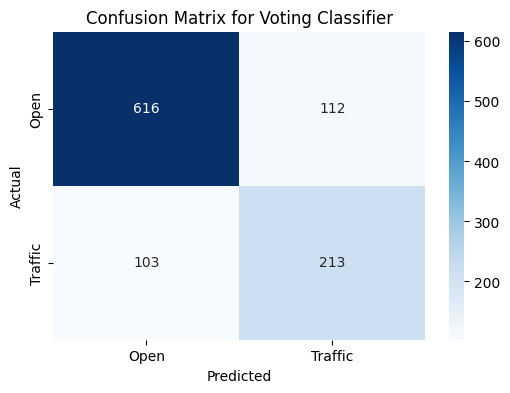

Model saved to voting_classifier_best_model.joblib


In [251]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib  # For saving the model
from scipy.stats import randint, uniform

clf1 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
clf2 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf3 = GradientBoostingClassifier(random_state=42)  # Doesn't support class_weight
clf4 = SVC(probability=True, random_state=42, class_weight='balanced')

voting_clf = VotingClassifier(
    estimators=[
        ('lr', clf1),
        ('rf', clf2),
        ('gb', clf3),
        ('svc', clf4)
    ],
    voting='soft',
    weights=[2, 2, 1, 1]  # Assign higher weights to more reliable classifiers
)

param_distributions = {
    'rf__n_estimators': randint(100, 300),
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': randint(2, 11),
    'gb__n_estimators': randint(100, 300),
    'gb__learning_rate': uniform(0.01, 0.19),  # 0.01 to 0.2
    'gb__max_depth': [3, 5],
    'lr__C': uniform(0.1, 9.9),  # 0.1 to 10
    'svc__C': uniform(0.1, 9.9),  # 0.1 to 10
    'svc__gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(
    estimator=voting_clf,
    param_distributions=param_distributions,
    n_iter=50,          # Number of parameter settings sampled
    cv=5,               # 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,          # Utilize all available cores
    verbose=1
)

random_search.fit(X_train, y_train_labels)
print(f"Best Parameters: {random_search.best_params_}")
best_model = random_search.best_estimator_
y_pred_voting = best_model.predict(X_test)
accuracy_voting = accuracy_score(y_test_labels, y_pred_voting)
print(f"\nVoting Classifier Test Accuracy: {accuracy_voting:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_voting, target_names=le_status.classes_))

cm = confusion_matrix(y_test_labels, y_pred_voting)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_status.classes_,
            yticklabels=le_status.classes_)
plt.title('Confusion Matrix for Voting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 11. Save the Best Model
joblib.dump(best_model, 'voting_classifier_best_model.joblib')
print("Model saved to voting_classifier_best_model.joblib")


In [255]:
joblib.dump(checkpoint_encoder, 'checkpoint_encoder.joblib')

['checkpoint_encoder.joblib']

In [256]:
import sklearn
print(sklearn.__version__)

1.3.2


In [257]:
feature_columns

['hour_sin',
 'hour_cos',
 'day_sin',
 'day_cos',
 'checkpoint_17 عصيرة',
 'checkpoint_DCO',
 'checkpoint_الباذان',
 'checkpoint_الحمرا',
 'checkpoint_الغرس بزاريا',
 'checkpoint_المربعة',
 'checkpoint_بزاريا',
 'checkpoint_بوابة النبي صالح',
 'checkpoint_بوابة بورين',
 'checkpoint_بوابة جماعين',
 'checkpoint_بوابة دير ابو مشعل',
 'checkpoint_بوابة عابود',
 'checkpoint_بوابة عقربا',
 'checkpoint_بيت ايل',
 'checkpoint_بيت فوريك',
 'checkpoint_ترمسعيا',
 'checkpoint_جسر اودلا',
 'checkpoint_جلزون',
 'checkpoint_جيت',
 'checkpoint_دير بلوط',
 'checkpoint_دير شرف',
 'checkpoint_روابي',
 'checkpoint_زعترة',
 'checkpoint_سنجل',
 'checkpoint_شافي شمرون',
 'checkpoint_صرة',
 'checkpoint_طنيب',
 'checkpoint_عطارة',
 'checkpoint_عورتا',
 'checkpoint_عوفرا',
 'checkpoint_عيلي',
 'checkpoint_عين سينيا',
 'checkpoint_عيون الحرامية',
 'checkpoint_كرملو',
 'checkpoint_مخماس']